<a href="https://colab.research.google.com/github/robotwai/learn_train_model/blob/main/Demos/Emoji-Gemma-on-Web/resources/Fine_tune_Gemma_3_270M_for_emoji_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2025 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
  <td>
      <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Demos/Emoji-Gemma-on-Web/resources/Fine_tune_Gemma_3_270M_for_emoji_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Fine-tune Gemma 3 270M for emoji generation

This notebook fine-tunes Gemma for the task of translating text into emoji using Quantized Low-Rank Adaptation (QLoRA) through the Hugging Face Transformer Reinfocement Learning ([TRL](https://huggingface.co/docs/trl/en/index)) library to help reduce memory usage and speed up the fine-tuning process.

When training [Gemma 3 270M](https://huggingface.co/google/gemma-3-270m) on a Google Colab T4 GPU accelerator, this process can take as little as 10 minutes end-to-end. Run each code snippet to:

1. Set up the Colab environment
2. Prepare a dataset for fine-tuning
3. Load and test the base Gemma 3 270M model
4. Fine-tune the model
5. Test, evaluate, and save the model for further use

## Set up development environment

The first step is to install the necessary libraries using the `pip` package installer.

In [2]:
%pip install torch tensorboard emoji
%pip install -U transformers trl datasets accelerate evaluate sentencepiece bitsandbytes protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
     

You may have the restart your session (runtime) to use newly installed libraries.

##Enable Hugging Face permissions
To use Gemma models, you'll need to accept the model usage license and create an Access Token:

1. **Accept license** on the [model page](http://huggingface.co/google/gemma-3-270m-it).

2. **Get a valid [Access Token](https://huggingface.co/settings/tokens) with 'Write' access (very important!)**

3. Create a new Colab secret in the left toolbar. Specify `HF_TOKEN` as the 'Name', add your unique token as the 'Value', and toggle 'Notebook access' on.

In [4]:
from google.colab import userdata
from huggingface_hub import login

# Login into Hugging Face Hub
hf_token = ''
login(hf_token)

## Load the dataset

Hugging Face hosts a large collection of datasets for training and evaluating models. If you're not using a custom dataset, you can load a [premade dataset](https://huggingface.co/datasets/kr15t3n/g-emoji) containing examples of text and corresponding emoji translations.

**If you'd like to use your own custom dataset, skip to the next step.**

In [5]:
import emoji
from datasets import load_dataset

# Use the first 2000 samples for efficient training.
general_dataset_path = load_dataset("kr15t3n/text2emoji", encoding="utf-8", split="train")

# Clean dataset to only use examples where 'emoji' field contains only emoji characters
def is_only_emoji(sample):
  emoji_string = sample['emoji']
  if not emoji_string:
    return False
  return all(emoji.is_emoji(char) for char in emoji_string)
dataset = general_dataset_path.filter(is_only_emoji)

print(f"\nHere's the 10th example from the dataset: {dataset[10]}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/2529 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2529 [00:00<?, ? examples/s]


Here's the 10th example from the dataset: {'text': 'A supernova just exploded', 'emoji': '💥✨'}


### Upload a custom dataset
**If you've already loaded a dataset, skip this step.**


You can customize Gemma 3 270M to use specific emoji by creating a spreadsheet containing your text-to-emoji dataset structured as key-value pairs. If you want to encourage memorization of specific emoji, we recommend providing 10-20 examples of that emoji with different text variations.

Use a [premade dataset](https://github.com/google-gemini/gemma-cookbook/blob/main/Demos/Emoji-Gemma-on-Web/resources/Emoji%20Translation%20Dataset%20-%20Dataset.csv)  as a template to create your own dataset, then upload it the Files folder in the left toolbar. Get its path by right-clicking the file and pointing to it in `custom_dataset_path`.

In [ ]:
import emoji
from datasets import load_dataset
from transformers import AutoTokenizer

# Point to your uploaded dataset
custom_dataset_path = "/content/Emoji Translation Dataset - Dataset.csv"      #@param {type:"string"}
dataset = load_dataset("csv", data_files=custom_dataset_path, encoding="utf-8", split="train")

# Clean dataset to only use examples where 'emoji' field contains only emoji characters
def is_only_emoji(sample):
  emoji_string = sample['emoji']
  if not emoji_string:
    return False
  return emoji.purely_emoji(emoji_string)
dataset = dataset.filter(is_only_emoji)

print(f"\nHere's the 10th example from your dataset: {dataset[10]}")

## Load the model

You can access [Gemma 3 270M](https://huggingface.co/google/gemma-3-270m-it) from Hugging Face Hub by accepting the license terms. The instruction-tuned version of the model has already been trained on how to follow directions and with fine-tuning, you'll now adapt it to a new task.

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

gemma_model = "google/gemma-3-270m-it"
base_model = AutoModelForCausalLM.from_pretrained(gemma_model, device_map="auto", attn_implementation="eager", dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

print(f"Device: {base_model.device}")
print(f"DType: {base_model.dtype}")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


Device should print as `cuda` if you're using a GPU runtime. **If you haven't aleady, use a free T4 GPU runtime in your Colab for faster fine-tuning.**

### Format the training dataset
Now that you've loaded your data, format the training dataset into conversational roles, including the text input and emoji output, plus a system prompt that contains the direction to the model. This helps the model learn how to interpret the 'text' and 'emoji' columns from your dataset.

In [7]:
from transformers import AutoTokenizer

def translate(sample):
  return {
      "messages": [
          {"role": "system", "content": "Translate this text to emoji: "},
          {"role": "user", "content": f"{sample['text']}"},
          {"role": "assistant", "content": f"{sample['emoji']}"}
      ]
  }

training_dataset = dataset.map(translate, remove_columns=dataset.features.keys())
training_dataset_splits = training_dataset.train_test_split(test_size=0.1, shuffle=True)

print("\nHere's the 40th example from the formatted training dataset:")
print(training_dataset[40])

Map:   0%|          | 0/1519 [00:00<?, ? examples/s]


Here's the 40th example from the formatted training dataset:
{'messages': [{'content': 'Translate this text to emoji: ', 'role': 'system'}, {'content': 'Avoiding responsibilities', 'role': 'user'}, {'content': '🏃💨', 'role': 'assistant'}]}


### Recommended: Test the base model

Let's first check how the base model's ability to respond to the instruction "Translate this text to emoji"

Try testing it a few times.

In [8]:
from transformers import pipeline
from random import randint
import re

# Create a transformers inference pipeline
pipe = pipeline("text-generation", model=gemma_model, tokenizer=tokenizer)

# Select a random sample from the test dataset
rand_idx = randint(0, len(training_dataset_splits["test"]) - 1)
test_sample = training_dataset_splits["test"][rand_idx]

# Handle messages
all_messages = test_sample['messages']
user_message_content = next((msg['content'].strip() for msg in all_messages if msg['role'] == 'user'), "Not Found")
dataset_emoji = next((msg['content'].strip() for msg in all_messages if msg['role'] == 'assistant'), "Not Found")
prompt_messages = [
    {"role": "system", "content": "Translate this text to emoji: "},
    {"role": "user", "content": user_message_content}
]

# Apply the chat template. This will format the messages correctly for the model.
prompt = tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)

# Generate the output
output = pipe(prompt, max_new_tokens=64)
model_output_only = output[0]['generated_text'][len(prompt):].strip()

print(f"\nDataset text: {user_message_content}")
print(f"\nDataset emoji: {dataset_emoji}")
print(f"\nModel generated output: {model_output_only}")

Device set to use cuda:0



Dataset text: He really said that? Wow

Dataset emoji: 💀😂

Model generated output: Here are a few emoji translations of "He really said that?" :

*   **He really said that?** (Expressing a strong, positive sentiment)
*   **He really said that?** (Expressing a strong, positive sentiment)
*   **He really said that?** (Express


The base model output may not meet your expectations—and that's okay!

Gemma 3 270M was designed for task specialization, which means it can improve performance for specific tasks when trained with representative examples. Let's fine-tune the model for more reliable outputs.

## Fine-tune the model

Hugging Face [TRL](https://huggingface.co/docs/trl/index) provides tools for training and fine-tuning LLMs using memory-efficient techniques like QLoRA (Quantized Low-Rank Adaptation) to train adapters on top of a frozen quantized version of the model.

### Configure the tuning job
Define the training configuration for the Gemma 3 base model:

1. `BitsandBytesConfig` to quantize the model for memory efficiency
2. `LoraConfig` for parameter-efficient fine-tuning
2. `SFTConfig` for supervised fine-tuning

In [9]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig
from trl import SFTConfig

adapter_path = "/content/myemoji-gemma-adapters"      # Where to save your LoRA adapters
tokenizer = AutoTokenizer.from_pretrained(gemma_model)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules="all-linear",                      # Target all linear layers
    lora_dropout=0.1,                                # Increase to 0.1 to induce overfitting
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=["lm_head", "embed_tokens"]       # Save the lm_head and embed_tokens as you train the special tokens
)

args = SFTConfig(
    output_dir=adapter_path,                          # Directory to save adapters
    num_train_epochs=3,                               # Number of training epochs
    per_device_train_batch_size=4,                    # Batch size per device during training
    logging_strategy="epoch",                         # Log every epoch
    eval_strategy="epoch",                            # Evaluate loss metrics every epoch
    save_strategy="epoch",                            # Save checkpoint every epoch
    learning_rate=5e-5,                               # Learning rate,
    lr_scheduler_type="constant",                     # Use constant learning rate scheduler
    max_length=256,                                   # Max sequence length for model and packing of the dataset
    gradient_checkpointing=False,                     # Use gradient checkpointing to save memory
    packing=False,                                    # Groups multiple samples in the dataset into a single sequence
    optim="adamw_torch_fused",                        # Use fused adamw optimizer
    report_to="tensorboard",                          # Report metrics to tensorboard
    weight_decay=0.01,                                # Added weight decay for regularization
)

base_model = AutoModelForCausalLM.from_pretrained(gemma_model, quantization_config=bnb_config, device_map="auto", attn_implementation='eager')
base_model.config.pad_token_id = tokenizer.pad_token_id

print("Training configured")

Training configured


### Start training

`SFTTrainer` tokenizes the datasets and trains the base model using the hyperparameters from the previous step.

The training time varies based on a range of factors, such as the size of your dataset or number of epochs. Using a T4 GPU, this takes about 10 minutes for 1000 training examples. If training is going slowly, check that you're using a T4 GPU in Colab.

In [10]:
from trl import SFTConfig, SFTTrainer

# Set training and evaluation datasets
train_dataset = training_dataset_splits['train']
eval_dataset = training_dataset_splits['test']

# Train and save the LoRA adapters
trainer = SFTTrainer(
    model=base_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=lora_config,
)
trainer.train()
trainer.save_model(adapter_path)

print(f"LoRA adapters saved to {adapter_path}")

Tokenizing train dataset:   0%|          | 0/1367 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1367 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/152 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/152 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,1.685800,1.332831,1.365477,38494.000000,0.738780
2,1.107200,1.320507,1.011418,76988.000000,0.745301
3,0.907100,1.318319,0.972811,115482.000000,0.744898


LoRA adapters saved to /content/myemoji-gemma-adapters


The LoRA adapters for each training checkpoint (epoch) will be saved in your temporary Colab session storage. Now, you can evaluate the training and validation loss metrics to choose which adapters to merge with the model.

### Plot training results
To evaluate the model, you can plot the training and validation losses using Matplotlib to visualize these metrics over training steps or epochs. This helps monitor the training process and make informed decisions about hyperparameters or early stopping.

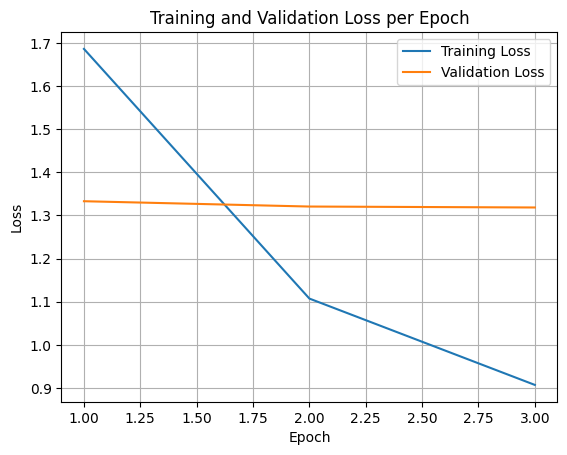

In [11]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

Training loss measures the error on the data the model was trained on. Validation loss measures the error on a separate dataset the model has not seen before. Monitoring both helps detect overfitting (when the model performs well on training data but poorly on unseen data).

- validation loss >> training loss: **overfitting**
- validation loss > training loss: **some overfitting**
- validation loss < training loss: **some underfitting**
- validation loss << training loss: **underfitting**

If your task requires memorization of specific examples, or specific emoji to be generated for a given text, overfitting can be beneficial.

### Merge the adapters

Once trained you can merge the LoRA adapters with the model. You can choose which adapters to merge by specifying the training checkpoint folder, otherwise it will default to the last epoch.
* For better task generalization, choose the most underfit checkpoint (validation loss < training loss)
* For better memorization of specific examples, choose the most overfit (checkpoint > training loss)  


In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

adapter_path = "/content/myemoji-gemma-adapters/"                 # Choose which adapters to merge, otherwise defaults to latest
merged_model_path = "/content/myemoji-gemma-merged/"              # Location of merged model directory

# Load base model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(gemma_model, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(adapter_path)

# Load and merge the PEFT adapters onto the base model
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

# Save the merged model and its tokenizer
model.save_pretrained(merged_model_path)
tokenizer.save_pretrained(merged_model_path)

print(f"Model merged and saved to {merged_model_path}. Final model vocabulary size: {model.config.vocab_size}")

Model merged and saved to /content/myemoji-gemma-merged/. Final model vocabulary size: 262144


### Test the fine-tuned model

Let's compare your fine-tuned model performance against the base model! Test a few inputs by updating `text_to_translate`.

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

# Create Transformers inference pipeline
merged_model = AutoModelForCausalLM.from_pretrained(merged_model_path, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(merged_model_path)
pipe = pipeline("text-generation", model=merged_model, tokenizer=tokenizer)
pipe_base = pipeline("text-generation", model=gemma_model, device_map="auto")

# Test a prompt
text_to_translate = "let's go to the beach"  #@param {type:"string"}
inference_messages = [
    {"role": "system", "content": "Translate this text to emoji: "},
    {"role": "user", "content": text_to_translate}
]
prompt = tokenizer.apply_chat_template(inference_messages, tokenize=False, add_generation_prompt=True)
output = pipe(prompt, max_new_tokens=128)
output_base = pipe_base(prompt, max_new_tokens=128)
model_output = output[0]['generated_text'][len(prompt):].strip()
model_output_base = output_base[0]['generated_text'][len(prompt):].strip()

print(f"\nFine-tuned model output: {model_output}")

print(f"\nBase model output: {model_output_base}")

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.
Device set to use cuda:0
Device set to use cuda:0



Fine-tuned model output: 🌊🏖☀️😎

Base model output: 


Does the model output the emoji you'd expect?

If you're not getting the results you want, you can try [using different hyperparameters](#scrollTo=-BJFoOdL0y8w) to train the model, or updating your training dataset to contain more representative examples.

Once you're happy with the results, you can save your model to Hugging Face Hub.

## Save your model and upload to Hugging Face Hub
**You now have a customized Gemma 3 270M model! 🎉**

Upload it to a repository on Hugging Face Hub so you easily share your model or access it later.

In [14]:
from huggingface_hub import ModelCard, ModelCardData, whoami

#@markdown Name your model
model_name = "myemoji"                            #@param {type:"string"}

username = whoami()['name']
hf_repo_id = f"{username}/{model_name}-gemma-3-270m-it"

repo_url = model.push_to_hub(hf_repo_id, create_repo=True, commit_message="Upload model")
tokenizer.push_to_hub(hf_repo_id)

card_content = f"""
---
base_model: {gemma_model}
tags:
- text-generation
- emoji
- gemma
---
A fine-tuned model based on `{gemma_model}`."""
card = ModelCard(card_content)
card.push_to_hub(hf_repo_id)

print(f"Uploaded to {repo_url}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...viam8n8/model.safetensors:   1%|          | 14.2MB / 1.74GB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...pw6o8f52s/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...mpw6o8f52s/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

Uploaded to https://huggingface.co/li798/myemoji-gemma-3-270m-it/commit/3e5361f0a7c9ee5b52751f660b771dea25698989


## Summary and next steps

This notebook covered how to efficiently fine-tune Gemma 3 270M for emoji generation. Continue on to the conversion and quantization steps to get it ready for on-device deployment. You can follow the steps to either:

1.  [Convert for use with MediaPipe LLM Inference API](https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Demos/Emoji-Gemma-on-Web/resources/Convert_Gemma_3_270M_to_LiteRT_for_MediaPipe_LLM_Inference_API.ipynb)
2.  [Convert for use with Transformers.js via ONNX Runtime](https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Demos/Emoji-Gemma-on-Web/resources/Convert_Gemma_3_270M_to_ONNX.ipynb)